# The Moran model and population genetics

The following tutorial utilizes materials from the following works:
- [*Probability models for DNA sequence evolution*, Durrett](https://services.math.duke.edu/~rtd/Gbook/PM4DNA_0317.pdf)
- [*Design of an optimal combination therapy with broadly neutralizing antibodies to suppress HIV-1*, LaMont & Nourmohammad et al.](https://elifesciences.org/articles/76004)
- [*From biophysics to evolutionary genetics: statistical aspects of gene
regulation*, section "Evolution of regulatory DNA," Lässig](https://bmcbioinformatics.biomedcentral.com/counter/pdf/10.1186/1471-2105-8-S6-S7.pdf#page=10)

# Import modules
___

In [1]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np

#plt.style.use('custom.mplstyle')
#%config InlineBackend.figure_format = 'retina'

# Introduction
___

The Moran model is used to evolve a fixed population of $N$ individuals forward in time and study population genetics phenomena. In contrast to other population genetics models, changes in the population occur asynchronously and are modeled in an individual-based fashion in the Moran framework. I.e., only one individual changes at a point in time as opposed to the *entire* population undergoing mutation, reproduction, etc. events in a single generation.

The Moran model can consider many genotypes in a population, but, for simplicity, we consider only two here: $a$ and $b$. $a$ and $b$ could represent two subpopulations such as [healthy and cancerous cells](https://link.springer.com/article/10.1007/s11538-005-9046-8) or [variants of virus, perhaps those susceptible to a treatment and those that aren't](https://elifesciences.org/articles/76004). On the other hand, we could also think of $a$ and $b$ merely as two populations with no significant implications. It all depends on our modeling goals and the parameters we employ when running the simulation.

# Moran neutral model
___

The simplest version of the Moran model seeks to describe neutral evolution, which means that neither $a$ nor $b$ individuals have any fitness advantage over the other. In this case, the model is characterized by the following. Let $x$ be the amount of individuals in the population that have genotype $a$. Due to the constraint on the population size, $n_a \in \{0, 1, 2, ..., N\}$. The reaction equations for $n_a$ are

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i& \text{rate, } k_i \\
n_a \rightarrow n_a+1,\;\;\;\; & b_a = (N-n_a) \frac{n_a}{N} \\[0.3em]
n_a \rightarrow n_a-1, \;\;\;\; & d_a = n_a \frac{N-n_a}{N} \\[0.3em]
\end{array}
\end{align}

where $b_a$ is the birth rate and $d_a$ is the death rate. For $n_a$ to increase by 1, an individual with genotype $b$ must die, and an individual with genotype $a$ must give birth. $b$ individuals die at rate $N - n_a$, and the probability that the new parent is an $a$ is $n_a / N$. Parallel reasoning follows for the definition of $d_a$. Observe that $b_a = d_a$ in the case of neutral evolution. Also note that each event that occurs over the run of the simulation is a combination of a death event and a birth event: this maintains the constant size of the population. In this particular configuration of the Moran model, any individual can die, and any individual can be the parent of the offspring that replaces the dead individual, including the one that has died. (In contrast, other configurations might put spatial constraints on which individuals can be the parent of the offspring.)

One of the fundamental questions that can be investigated with the Moran model is what is the probability that one of these subpopulations takes over the entire population and how long until that happens? A takeover event is referred to as fixation in population genetics literature; in mathematics, the state at which a takeover happens is called an absorbing state (once the state is entered, it cannot be left). Concretely, if the population originally was diverse and then $a$ became the only type of individual that exists in the population, $a$ has fixed. We will use this fixation condition to determine how long the simulation will be run since no dynamics occur after fixation in the neutral Moran model.

### Write a function that implements the Gillespie algorithm for the Moran neutral model.

It should have as its parameters:
- `pop_size`, the size of the population
- `num_a`, the number of $a$ individuals in the population 
- `T`, the time at which the simulations should end

It should return:
- `times`, a one-dimensional numpy array containing the times at which events have occurred
- `pop_history`, a one-dimensional numpy array containing the population composition over the course of the simulation

*Note: do not erase `@nb.njit`. It is what tells `numba` to compile our `neutral_moran` function, making it fast!*

In [2]:
@nb.njit
def neutral_moran(pop_size, num_a, T=np.inf):
    # Require that pop_size be an integer.
    # An exception is much "louder" than a print and return statement. 
    # See what happens when pop_size is not an integer.
    if pop_size != int(pop_size):
        raise TypeError('pop_size must be an integer.')
        
    # Require that num_a be an integer.
    if num_a != int(num_a):
        raise TypeError('num_a must be an integer.')
    
    # Require that num_a is bounded between 0 and pop_size.
    if num_a > pop_size or num_a < 0:
        raise ValueError('num_a must be in [0, pop_size]')
       
    # Require that T be a positive real number.
    if T <= 0.0:
        raise ValueError('T must be a positive real number.')
    
    # We don't use numpy arrays to store the times and pop_history
    # because we don't know how many events will occur.
    times = [0.0]
    pop_history = [num_a]
    
    # Let the simulation run until T is reached. If T is np.inf,
    # the simulation will be guaranteed to run until a fixation event
    # occurs.
    while times[-1] <= T:
        # Compute the number of b individuals.
        num_b = pop_size - num_a
        
        """
        Compute p, the fraction of individuals in the population with genotype a.
        """
        p = num_a / pop_size
        
        """
        Compute the birth rate using num_b and p.
        """
        birth_rate = num_b * p
        
        """
        Compute the death rate using num_a and p.
        """
        death_rate = num_a * (1 - p)
        
        """
        Save the sum of these two rates to a variable called sum_rates.
        """
        sum_rates = birth_rate + death_rate

        # When the population fixes, evolution stops since
        # the sum of the rates is 0.0. I.e., the time until
        # the next event is infinity.
        if sum_rates == 0.0:
            break
        
        """
        Use sum_rates and np.random.exponential to generate the time to the next event.
        Recall that np.random.exponential takes 1 / rate as its parameter.
        """
        interarrival_time = np.random.exponential(1 / sum_rates)
        
        """
        Append the overall elapsed time to the list of times.
        """
        times.append(times[-1] + interarrival_time)
        
        """
        Draw a random number using np.random.random().
        Use an if-else statement to determine whether the number of individuals
        with genotype a increases or decreases by 1 by using the event probabilities.
        """   
        rand = np.random.random()
        if rand <= birth_rate / sum_rates:
            num_a += 1
        else:
            num_a -= 1
        
        pop_history.append(num_a)
        
    return np.array(times), np.array(pop_history)

### Set $N = 100$, $n_a = 50$. Run the simulation 10 times and plot the population histories vs. their respective event times.

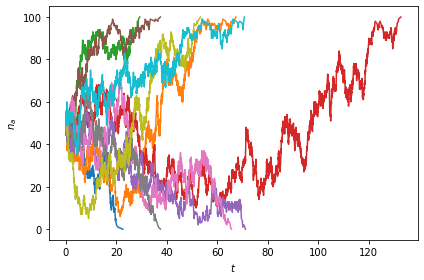

In [3]:
fig, ax = plt.subplots()

N = 100
num_a = 50

"""
Use a for loop and run your simulation and plot accordingly.
"""
for i in range(10):
    times, pop_history = neutral_moran(N, num_a)
    ax.plot(times, pop_history)

ax.set_xlabel('$t$')
ax.set_ylabel('$n_a$')
    
plt.tight_layout()
plt.show()

### What are the characteristics of the trajectories that you have observed?

**your answer:**

## Fixation probability for the neutral Moran model

Let $n_a(0)$ be the initial amount of individuals of type $a$ in the population. There are a few different ways to solve for the fixation probability. One way is to find the function $f(n_a)$ which does not change over time on average. Thus the goal is to find $f(n_a)$ such that

$$
f(n_a) = f(n_a + 1)P(n_a + 1 | n_a) + f(n_a - 1)P(n_a - 1 | n_a)
$$

because $n_a$ can only increase by $1$ or decrease by $1$ in a generation.

Since 

$$
\begin{align*}
P(n_a + 1 | n_a) &= \frac{b_a}{(b_a + d_a)} \\
P(n_a - 1| n_a) &= \frac{d_a}{(b_a + d_a)} \\
\end{align*}
$$

and $b_a = d_a$, these two probabilities are equal. Then

$$
f(n_a) = \frac{f(n_a + 1)}{2} + \frac{f(n_a - 1)}{2}
$$

The desired $f(n_a)$ is the identity function $f(n_a) = n_a$ since

$$
n_a = \frac{n_a + 1}{2} + \frac{n_a - 1}{2}
$$

Therefore

$$
\frac{d}{dt} \langle n_a(t) \rangle = 0 \quad \Rightarrow \quad n_a(0) = \langle n_a(t) \rangle \quad \forall t
$$

Because this holds for any time $t$, the expectation of $n_a$ when the population has fixed, which is guaranteed for neutral evolution without mutations when $t \to \infty$, is

$$
n_a(0) = \lim_{t \to \infty} \langle n_a(t) \rangle  = NP_{\mathrm{fix}}(n_a=N) + 0 P_{\mathrm{fix}}(n_a=0)
$$

Rearranging the above equation gives

$$
P_{\mathrm{fix}}(N) = \frac{n_a(0)}{N}
$$

## Fixation time for the neutral Moran model

Characterizing the average time until fixation occurs is much more involved to prove unfortunately, so we state the results. (See [Theorem 1.32](https://services.math.duke.edu/~rtd/Gbook/PM4DNA_0317.pdf#page=57) in Durrett.) Letting $p = n_a(0) / N$, the expected time until fixation is 

$$
\langle t_{\mathrm{fix}} \rangle \approx \frac{-N(1 - p)}{p} \log(1 - p)
$$

for large enough $N$.

### When $p \ll 1$, what is the expected time to fixation?

Hint: recognize which terms diverge and apply L'Hopital's rule.

**your answer:**

### Set $N = 100$. Run the simulation $5000$ times for $n_a \in \{1, 5, 10, 15, 20, ..., 85, 95, 99\}$. Obtain the probabilities of fixation and the times until fixation.

Note: because we are expecting $a$ to fixate, only simulations that end with $n_a = N$ should be used to compute the probabilities.

In [4]:
N = 100
num_a_arr = np.concatenate([[1], np.arange(5, 100, 5), [99]])

num_runs = 5000

fixation_probs = np.zeros(len(num_a_arr))

# We initialize the array to np.nan to ignore simulations
# for which fixation was not realized more easily.
fixation_times = np.zeros((len(num_a_arr), num_runs)) + np.nan

for idx, num_a in enumerate(num_a_arr):
    for runidx in range(num_runs):
        times, pop_history = neutral_moran(N, num_a)
        if pop_history[-1] == N:
            fixation_probs[idx] += 1
            fixation_times[idx, runidx] = times[-1]
            
fixation_probs /= num_runs

### Plot the fixation probabilities from simulation as a scatter and the theory as a line, and do the same for the average time until fixation.

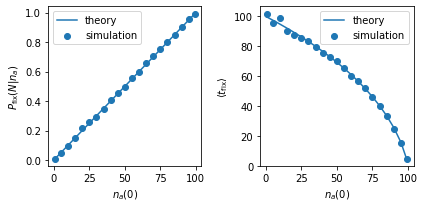

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3))

def fix_theory(N, num_a_0):
    p = num_a_0 / N
    return -N * (1 - p) / p * np.log(1 - p)

axes[0].scatter(num_a_arr, fixation_probs, label='simulation')
axes[0].plot(num_a_arr, num_a_arr / N, label='theory')

axes[0].set_xlabel('$n_a(0)$')
axes[0].set_ylabel('$P_{\mathrm{fix}}(N | n_a )$')
axes[0].legend()

axes[1].scatter(num_a_arr, np.nanmean(fixation_times, axis=1), label='simulation')
axes[1].plot(num_a_arr, fix_theory(N, num_a_arr), label='theory')

axes[1].set_xlabel('$n_a(0)$')
axes[1].set_ylabel('$\\langle t_{\mathrm{fix}} \\rangle$')

axes[1].legend()

plt.tight_layout()
plt.show()

### How do the simulations and theory compare?

**your answer:**

# Moran model with constant directional selection and mutations
___

We now add selection and mutation into the Moran model. Evolutionary fitness can be interpreted as a genotype's (here, $a$ or $b$) ability to produce offspring in the next generation compared to other individuals. I.e., fitness is rate at which different types of individuals reproduce. Crucially, a genotype's fitness depends on the environment in which it exists. Selection is the process by which the population is shaped over time by these fitness differences and is the most responsible for a population's adaptation to the evironment. Mutations are errors made in an genotype during replication or reproduction. While this may not change the composition of the population as strongly as selection, mutations can introduce novel genotypes into a population. 

For the moment, we consider constant selection. Let $1$, $1-s$ with $s \in (0, 1]$ be the relative fitnesses of $a$ and $b$, respectively. Note that $s \ll 1$ typically. In this way, fitness is the probability that an offspring from that individual is successful. Additionally, let $\mu$ be the rate at which one individual changes to another. Here, the mutation rate is the same irrespective of an individual's type; however, more complicated models could have individual-specific mutation rates $\mu_{a \to b}$, $\mu_{b \to a}$, etc.

With these two evolutionary processes, the reaction equations describing this Moran model are

\begin{align}
\begin{array}{ll}
\text{reaction, }r_i& \text{rate, } k_i \\
n_a \rightarrow n_a+1,\;\;\;\; & b_a = (N-n_a) \frac{n_a}{N} \\[0.3em]
n_a \rightarrow n_a-1, \;\;\;\; & d_a = n_a \frac{N-n_a}{N} (1 - s) \\[0.3em]
n_a \rightarrow n_a+1, \;\;\;\; & \pi_{b \to a} = (N - n_a) \mu \\[0.3em]
n_a \rightarrow n_a-1, \;\;\;\; & \pi_{a \to b} = n_a \mu \\[0.3em]
\end{array}
\end{align}

The birth and death reaction rates are obtained by noting:

- each individual has equal replacement rates
    - e.g., the rate at which an individual of type $a$ is chosen to be replaced is $n_a$
- an individual with genotype $a$ replaces the dead individual with probability given by $n_a / N$
- the new individual is accepted with probability equal to its fitness

Observe that fixation or loss is not guaranteed when $\pi_{b \to a} \neq 0$ and $\pi_{a \to b} \neq 0$. As $t \to \infty$, variants can arise; however, they may not persist forever, and the population can fix once again.

This Moran model incorporating mutations and reproduction with selection is coded below as a parallel (decoupled) mutation-reproduction model. I.e., mutations and reproduction occur independently. The Moran model can be implemented in a coupled fashion so that mutations can happen with some probability only after a birth event has taken place. For more information about coupled and decoupled models, see [this paper](https://link.springer.com/content/pdf/10.1007/s00285-006-0039-5.pdf).

In [6]:
@nb.njit
def sel_mut_moran(pop_size, num_a, sel_coef, mu, T=np.inf):
    # We include exceptions to ensure the parameters are in the expected
    # range of values and the expected types otherwise the function will
    # not run.
    
    # Require that pop_size be an integer.
    if pop_size != int(pop_size):
        raise TypeError('pop_size must be an integer.')
        
    # Require that num_a be an integer.
    if num_a != int(num_a):
        raise TypeError('num_a must be an integer.')
    
    # Require that num_a is bounded between 0 and pop_size.
    if num_a > pop_size or num_a < 0:
        raise ValueError('num_a must be in [0, pop_size]')
        
    # Require that T be a positive real number.
    if T <= 0.0:
        raise ValueError('T must be a positive real number.')
        
    # Require that mut_ab be a positive real number.
    if mu < 0.0:
        raise ValueError('mu must be a nonnegative real number.')
        
    # Require that T be finite if both mutation rates are nonzero.
    # Though fixation can be reached when both mutation rates are nonzero,
    # there are choices of mutation rates for which fixation will never
    # occur. Additionally, because substitution events can happen,
    # evolution doesn't stop when fixations or losses occur with nonzero
    # mutation rates.
    if T == np.inf and mu > 0:
        raise ValueError('T cannot be np.inf when mu is nonzero. T must be '
                         'finite otherwise the simulation will run forever.')
    
    # We don't use numpy arrays to store the times and pop_history
    # because we don't know how many events will occur.
    times = [0.0]
    pop_history = [num_a]
    
    while times[-1] <= T:
        # Compute the number of b individuals.
        num_b = pop_size - num_a
        
        """
        Compute p, the fraction of individuals in the population with genotype a.
        """
        p = num_a / pop_size
        
        """
        Compute the birth rate using p.
        """
        birth_rate = num_b * p
        
        """
        Compute the death rate using p.
        """
        death_rate = num_a * (1 - p) * (1 - sel_coef)
        
        """
        Compute the rate for a mutating to b.
        """
        pi_a_to_b = num_a * mu
        
        """
        Compute the rate for b mutating to a.
        """
        pi_b_to_a = num_b * mu
        
        """
        Save the sum of these four rates to a variable called sum_rates.
        """
        sum_rates = birth_rate + death_rate + pi_a_to_b + pi_b_to_a
        
        # When the population fixes and mutations are not allowed,
        # evolution stops since the sum of the rates is 0.0.
        # I.e., the time until the next event is infinity.
        if sum_rates == 0.0:
            break

        """
        Use sum_rates and np.random.exponential to generate the time to the next event.
        Recall that np.random.exponential takes 1 / rate as its parameter.
        """
        interarrival_time = np.random.exponential(1 / sum_rates)
        
        """
        Append the overall elapsed time to the list of times.
        """
        times.append(times[-1] + interarrival_time)
        
        """
        Draw a random number using np.random.random().
        Use an if-else statement to determine whether the number of individuals
        with genotype a increases or decreases by 1 by using the event probabilities.
        """
        rand = np.random.random()
        if rand <= (pi_b_to_a + birth_rate) / sum_rates:
            num_a += 1
        else:
            num_a -= 1
        
        pop_history.append(num_a)
        
    return np.array(times), np.array(pop_history)

## Fixation probability with selection

Assume $s \in (0, 1]$. The probability of a birth event happening before a death event is

$$
P(n_a + 1 | n_a) = \frac{b_a}{b_a + d_a} = \frac{(N-n_a)n_a/N}{(N-n_a)n_a/N + (1-s)(N-n_a)n_a/N} = \frac{1}{2 - s}
$$

Again, we desire an $f(n_a)$ which does not change on average to assist us in solving for the fixation probability.

$$
f(n_a) = f(n_a + 1) P(n_a + 1 | n_a)  + f(n_a - 1) P(n_a - 1| n_a) 
$$

It turns out that the desired functional form is $f(n_a) = (1 - s)^{n_a}$:

$$
\begin{align*}
(1 - s)^{n_a} &= (1-s)^{n_a + 1} \frac{b_a}{b_a + d_a} + (1-s)^{n_a - 1} \frac{d_a}{b_a + d_a} \\
&= (1-s)^{n_a + 1} \frac{1}{2 - s} + (1-s)^{n_a - 1} \frac{1-s}{2 - s} \\
&= (1-s)^{n_a} \left(\frac{1 - s}{2-s} + \frac{1}{2 - s} \right)
\end{align*}
$$

Therefore

$$
\frac{d}{dt} \langle (1-s)^{n_a(t)} \rangle = 0 \quad \Rightarrow \quad (1-s)^{n_a(0)} = \langle (1-s)^{n_a(t)} \rangle \quad \forall t
$$

Taking $t \to \infty$ to guarantee fixation (assuming no mutations occur)

$$
(1 - s)^{n_a(0)} = \lim_{t \to \infty} \langle (1-s)^{n_a(t)} \rangle = (1 - s)^N P_{\mathrm{fix}}(N) + (1-s)^0 P_{\mathrm{fix}}(0)
$$

In the limit of $t \to \infty$, because there are only two absorbing states, $n_a = N$ or $n_a = 0$, $P_{\mathrm{fix}}(0) = 1 - P_{\mathrm{fix}}(N)$.

$$
(1 - s)^{n_a(0)} = (1-s)^N P_{\mathrm{fix}}(N) + (1 - P_{\mathrm{fix}}(N))
$$

Solving for $P(N)$ we have

$$
P_{\mathrm{fix}}(N| n_a(0)) = \frac{1 - (1-s)^{n_a(0)}} {1 - (1-s)^N}
$$

### What is probability of fixation $P_{\mathrm{fix}}(N)$ in the limit of weak selection ($s \to 0$)?

**your answer:**

###  What is the probability of fixation $P_{\mathrm{fix}}(N)$ in the limit of strong selection ($Ns$ is large)?

**your answer:**

### Set $N = 100$. Run the simulation $5000$ times with $\mu = 0$ and $s = 0.01$ for $n_a \in \{1, 5, 10, 15, 20, ..., 85, 95, 99\}$. Obtain the fixation probabilities and fixation times.

Note: because we are expecting $a$ to fixate, only simulations in which $n_a = N$ should be used to compute the probabilities.

In [7]:
N = 100
num_a_arr = np.concatenate([[1], np.arange(10, 100, 10), [99]])
s = 0.01
num_runs = 5000

fixation_probs = np.zeros(len(num_a_arr))

# We initialize the array to np.nan to ignore simulations
# for which fixation was not realized more easily.
fixation_times = np.zeros((len(num_a_arr), num_runs)) + np.nan

for idx, num_a in enumerate(num_a_arr):
    for jdx in range(num_runs):
        times, pop_history = sel_mut_moran(N, num_a, s, 0)
        if pop_history[-1] == N:
            fixation_probs[idx] += 1
            fixation_times[idx, jdx] = times[-1]
            
fixation_probs /= num_runs

### Plot the average fixation probabilities from simulation as a scatter and the theory as a line, and plot the average fixation times from simulation as a scatter.

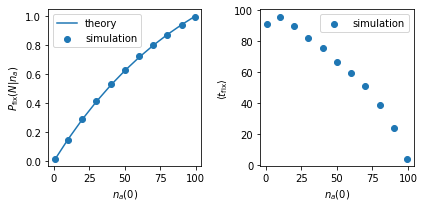

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(6, 3))

axes[0].plot(num_a_arr,
             (1 - (1 - s)**num_a_arr) / (1 - (1 - s)**N),
             label='theory')
axes[0].scatter(num_a_arr, fixation_probs, label='simulation')

axes[0].set_xlabel('$n_a(0)$')
axes[0].set_ylabel('$P_{\mathrm{fix}}(N | n_a )$')
axes[0].legend()

axes[1].scatter(num_a_arr,
                np.nanmean(fixation_times, axis=1),
                label='simulation')

axes[1].set_xlabel('$n_a(0)$')
axes[1].set_ylabel('$\\langle t_{\mathrm{fix}} \\rangle$')
axes[1].legend()

plt.tight_layout()
plt.show()

### How do the simulations and theory compare? Try out different values of $s$. How do the simulations compare to the asymptotic results?

**your answer:**

## Substitution events

When $N \mu \ll 1$ and $s \ll 1$, an interesting phenomenon can occur. In this regime, the absorbing states ($n_a = 0$ or $n_a = N$) can be reached and are unstable because of the nonzero mutation rates. Even with small values of $\pi_{a \to b}$, $\pi_{b \to a}$, the entire population can transition from being fixed at $a$ to being fixed at $b$ or vice versa. This transition is called a substitution. The rate at which substitutions occur during neutral evolution and with selection can be computed. (For further reading, see the section on [substitution dynamics](https://bmcbioinformatics.biomedcentral.com/counter/pdf/10.1186/1471-2105-8-S6-S7.pdf#page=13) in Lässig's overview.) To get a better intuition for the substitution rate, the mutation rate is equal to the substitution rate for neutral evolution.

We supply a function that helps find the time intervals in which substitution events take place.

In [11]:
def find_substitution_intervals(times, pop_history, N):
    pop_hist_normed = pop_history / N
    
    # Obtain the indices of the loss events in the pop_history trajectory.
    where_0_fix = np.where(pop_hist_normed == 0)[0]
    num_0_fix = len(where_0_fix)
    # There must be loss events for substitutions to occur.
    if len(where_0_fix) == 0:
        return
    
    # Obtain the indices of the fixation events in the pop_history trajectory.
    where_1_fix = np.where(pop_hist_normed == 1)[0]
    num_1_fix = len(where_1_fix)
    # There must be fixation events for substitutions to occur.
    if len(where_1_fix) == 0:
        return
    
    # Concatenate the indices of where the loss and fixation events
    # occur in the population histories.
    where_concat = np.concatenate([where_0_fix, where_1_fix])
    
    # Get the positions of the sorted trajectory indices.
    # This essentially weaves the loss and fixation trajectory
    # indices together and will be used to find substitution events.
    where_concat_argsort = np.argsort(where_concat)
    
    # Obtain the sorted trajectory indices of when loss and fixation
    # events occured.
    where_concat_sort = where_concat[where_concat_argsort]
    
    # A substitution event has occurred when the difference in positions
    # is greater than one.
    substitutions = np.where(np.diff(where_concat_argsort) != 1)[0]
    
    # Obtain the times at which absorbing states are observed.
    fix_event_times = times[where_concat_sort]
    
    # Obtain the starting times (column 0) and ending times (column 1)
    # of substitution events.
    substitution_intervals = np.array([fix_event_times[substitutions],
                                        fix_event_times[substitutions + 1]]).T
    
    return substitution_intervals

### Set $N = 100$. Run the simulation once with $n_a = 50$, $s = 0.01$, and $\mu = 0.001$. Set $T = 10000$. Plot the trajectory and label the substitution events.

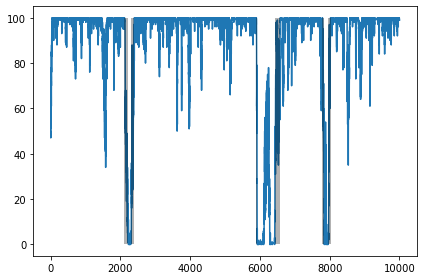

In [12]:
fig, ax = plt.subplots()

N = 100
num_a = 50
s = 0.01
mu = 0.001
T = 10000

times, pop_history = sel_mut_moran(N, num_a, s, mu, T)
substitution_intervals = find_substitution_intervals(times, pop_history, N)

ax.plot(times, pop_history)

if substitution_intervals is not None:
    for interval in substitution_intervals:
        ax.fill_between(interval, 0, N, alpha=0.3,
                        color='k', zorder=10, linewidth=0)

    
plt.tight_layout()
plt.show()

### Set $s=0$. Do you still see substitution events? What's the highest you can set $s$ before you stop seeing substitution events? Why is that?

**your answer:**

### If $N \mu \ll 1$ does not hold, what happens to substitution events?

**your answer:**

### Run the simulation $1000$ times with $N=100$, $n_a(0) = 50$, $s = 0$, and $\mu = 0.001$. Set $T = 10000$. Obtain the differences between the start of substitution events if substitution events occurred.

In [11]:
num_runs = 1000
time_between_subs = []

N = 100
num_a = 50
s = 0
mu = 0.001
T = 10000

for _ in range(num_runs):
    times, pop_history = sel_mut_moran(N, num_a, s, mu, T)
    substitution_intervals = find_substitution_intervals(times, pop_history, N)
    if substitution_intervals is not None:
        time_between_subs.append(np.diff(substitution_intervals, axis=0)[:, 0])
        
time_between_subs = np.concatenate(time_between_subs)

### Plot a histogram of the interarrival times between substitution events. Plot the expected time between substitution events as a vertical dashed line.

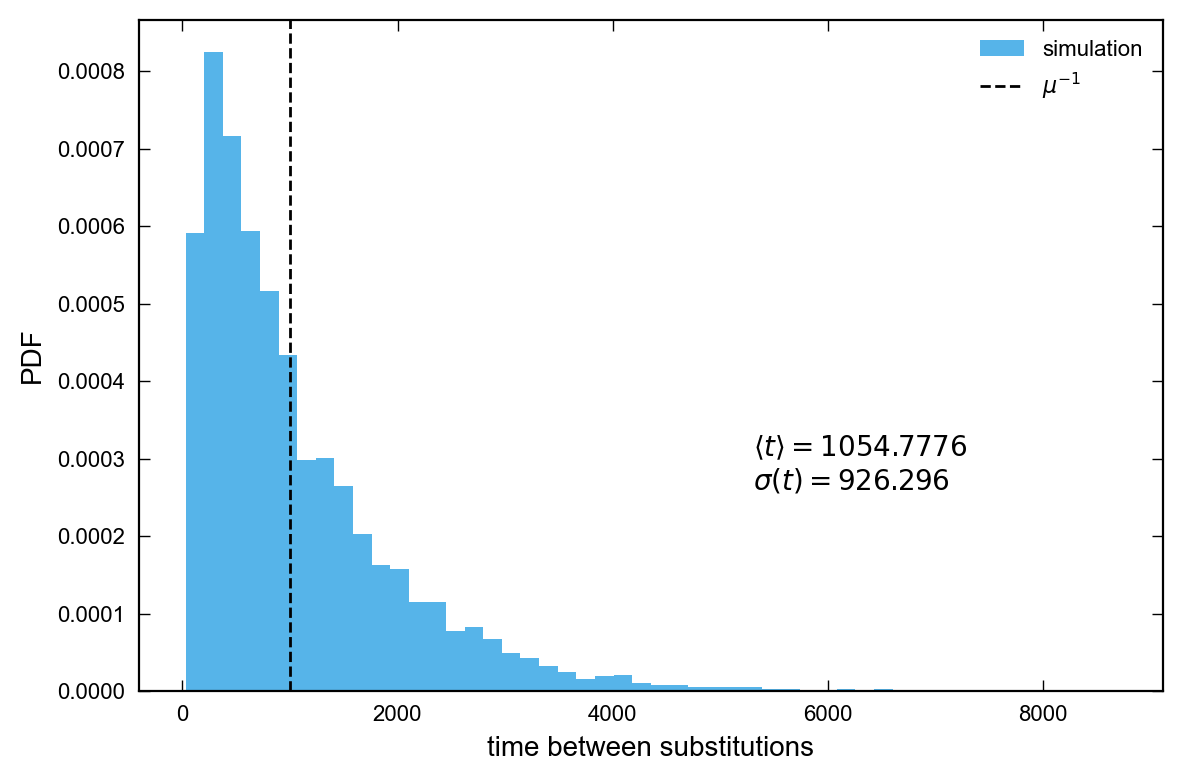

In [12]:
fig, ax = plt.subplots()

ax.hist(time_between_subs, label='simulation', density=True, bins=50)
ax.axvline(1/mu, color='k', linestyle='--', zorder=10, label='$\mu^{-1}$')

text = ('$\\langle t \\rangle = ' + str(np.round(np.mean(time_between_subs), 4)) + '$\n'
            + '$\sigma(t) = ' + str(np.round(np.std(time_between_subs), 4)) + '$')
ax.annotate(text, xy=(0.6, 0.3), color='black', xycoords='axes fraction')

ax.set_xlabel('time between substitutions')
ax.set_ylabel('PDF')

ax.legend()

plt.tight_layout()
plt.show()

### Roughly what kind of distribution is this? Justify your answer.

**your answer:**